In [1]:
import sys
sys.path.append('../../../')
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence
from tifffile import imread
from tqdm import tqdm
import inspect

In [29]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
patch_size = 64
centre_size = 4
n_channel = 32
hierarchy_level = 5
limit = 400
first_model = ' finetuned w cosine'
second_model = ' finetuned w KL'

In [3]:
def load_model(dir):
    model = torch.load(dir+"Contrastive_MAE_best_vae.net")
    return model

In [4]:
def load_losses(dir):
    trainHist=np.load(dir+"train_loss.npy")
    reconHist=np.load(dir+"train_reco_loss.npy")
    klHist=np.load(dir+"train_kl_loss.npy")
    clHist=np.load(dir+"train_cl_loss.npy")
    valHist=np.load(dir+"val_loss.npy")
    return [trainHist, reconHist, klHist, clHist, valHist]

In [5]:
def plot_loss(losses):

    plt.figure(figsize=(18, 18))

    plt.subplot(2,2,1)
    plt.plot(losses['trainHist'],label='training')
    plt.plot(losses['valHist'],label='validation')
    plt.xlabel("epochs")
    plt.ylabel("overall loss")
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(losses['reconHist'],label='training')
    plt.xlabel("epochs")
    plt.ylabel("Inpainting loss")
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(losses['klHist'],label='training')
    plt.xlabel("epochs")
    plt.ylabel("KL loss")
    plt.legend()

    plt.subplot(2,2,4)
    plt.plot(losses['clHist'],label='training')
    plt.xlabel("epochs")
    plt.ylabel("CL loss")
    plt.legend()
    plt.show()

In [6]:
def plot_double_loss(base_loss, cl_loss):
    
    plt.figure(figsize=(18, 18))
    plt.subplot(2,2,1)
    plt.plot(base_loss['trainHist'],label='training'+first_model)
    plt.plot(base_loss['valHist'],label='validation'+first_model)

    plt.plot(cl_loss['trainHist'],label='training'+second_model)
    plt.plot(cl_loss['valHist'],label='validation'+second_model)

    plt.xlabel("epochs")
    plt.ylabel("overall loss")
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(base_loss['reconHist'],label='training'+first_model)

    plt.plot(cl_loss['reconHist'],label='training'+second_model)

    plt.xlabel("epochs")
    plt.ylabel("Inpainting loss")
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(base_loss['klHist'],label='training'+first_model)

    plt.plot(cl_loss['klHist'],label='training'+second_model)

    plt.xlabel("epochs")
    plt.ylabel("KL loss")
    plt.legend()

    plt.subplot(2,2,4)
    plt.plot(base_loss['clHist'],label='training'+first_model)

    plt.plot(cl_loss['clHist'],label='training'+second_model)

    plt.xlabel("epochs")
    plt.ylabel("CL loss")
    plt.legend()
    plt.show()

In [7]:
def get_normalized_tensor(img,model,device):
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [8]:
def cos_similarity(z1, z2):
    z1 = torch.from_numpy(z1)
    z2 = torch.from_numpy(z2)
    return torch.mean(F.cosine_similarity(z1, z2, dim=-1))

In [9]:
def euc_dis(z1, z2):
    return np.mean(np.sqrt(((z1-z2)**2).sum(axis=1)))

In [10]:
def kl_d(z1, z2):
    m1, logv1 = z1
    m2, logv2 = z2
    m1 = torch.from_numpy(m1)
    logv1 = torch.from_numpy(logv1)
    m2 = torch.from_numpy(m2)
    logv2 = torch.from_numpy(logv2)
    std1 = (logv1 / 2).exp()
    std2 = (logv2 / 2).exp()
    dis1 = Normal(m1, std1)
    dis2 = Normal(m2, std2)
    temp = kl_divergence(dis1, dis2)
    temp = torch.reshape(temp, (-1, 32))
    return torch.mean(temp)

In [11]:
def get_centre(x, i):
    if i == 3:
        return x[i][0].cpu().numpy()
    elif i == 4:
        return x[i][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)
    else:
        lower_bound = 2**(hierarchy_level-1-i)-int(centre_size/2)
        upper_bound = 2**(hierarchy_level-1-i)+int(centre_size/2)
        return x[i][0].cpu().numpy()[:,lower_bound:upper_bound,lower_bound:upper_bound]

In [12]:
def get_distance(model, z1, z2, mode):
    n_features = n_channel * hierarchy_level
    data1 = np.zeros((n_features, centre_size, centre_size))
    data2 = np.zeros((n_features, centre_size, centre_size))
    model.mode_pred=True
    model.eval()
    model.to(device)
    z1 = z1.to(device=device, dtype=torch.float)
    z1 = z1.reshape(1,1,patch_size,patch_size)
    z2 = z2.to(device=device, dtype=torch.float)
    z2 = z2.reshape(1,1,patch_size,patch_size)
    with torch.no_grad():
            sample1 = model(z1, z1)
            sample2 = model(z2, z2)
            mu1 = sample1['mu']
            mu2 = sample2['mu']
            for i in range(hierarchy_level):
                data1[i*n_channel:(i+1)*n_channel] = get_centre(mu1, i)
                data2[i*n_channel:(i+1)*n_channel] = get_centre(mu2, i)
            data1 = data1.T.reshape(-1,n_features)
            data2 = data2.T.reshape(-1,n_features)

            if mode == 'euclidean distance':
                return euc_dis(data1, data2)
            elif mode == 'cosine similarity':
                return cos_similarity(data1, data2)
            elif mode == 'kl divergence':
                data3 = np.zeros((n_features, centre_size, centre_size))
                data4 = np.zeros((n_features, centre_size, centre_size))
                logvar1 = sample1['logvar']
                logvar2 = sample2['logvar']
                for i in range(hierarchy_level):
                    data3[i*n_channel:(i+1)*n_channel] = get_centre(logvar1, i)
                    data4[i*n_channel:(i+1)*n_channel] = get_centre(logvar2, i)
                data3 = data3.T.reshape(-1,n_features)
                data4 = data4.T.reshape(-1,n_features)
                return kl_d([data1, data3], [data2,data4])
            

In [13]:
def plot_single_hist(hist, label):
    n_bins = 100
    _, axs = plt.subplots(1, 1, sharey=False, tight_layout=False)
    plt.title(label)
    axs.hist(hist, bins=n_bins)
    

In [14]:
def plot_double_hist(hist, label, title):
    plt.hist(hist, bins=100, label=label)
    plt.title(title)
    plt.legend()
    plt.show()

In [15]:
def plot_triple_hist(hist, label, title):
    plt.hist(hist, bins=20, label=label)
    plt.title(title)
    plt.legend()
    plt.show()

In [16]:
def compute_pos_hist(data, model, mode):
    hist = []
    for i in tqdm(range(int(len(data)/2))):
        hist.append(get_distance(model,data[i],data[len(data)-i-1],mode))
    return hist

In [17]:
def compute_neg_hist(class1, class2, limit, model, mode):
    hist = []
    for i in tqdm(range(limit)):
        hist.append(get_distance(model, class1[i], class2[i], mode))
    return hist

In [18]:
def load_data(dir):
    return imread(dir)

In [32]:
base_dir = "/group/jug/Sheida/HDN_models/27022024/Contrastive_False/model/"
base_dir = "/group/jug/Sheida/HDN_models/27022024/Contrastive_false_finetuned_cosine/model/"
cl_dir = "/home/sheida.rahnamai/GIT/HDN/examples/Pixel_Noise/Convallaria/Contrastive_false_finetuned_KL/model/"
data_dir = "/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/"

In [33]:
model_base = load_model(base_dir)
model_cl = load_model(cl_dir)
loss_keys = ['trainHist', 'reconHist', 'klHist', 'clHist', 'valHist']
base_loss_dict = dict()
cl_loss_dict = dict()
base_losses = load_losses(base_dir)
cl_losses = load_losses(cl_dir)
for index, key in enumerate(loss_keys):
    base_loss_dict[key] = base_losses[index]
    cl_loss_dict[key] = cl_losses[index]

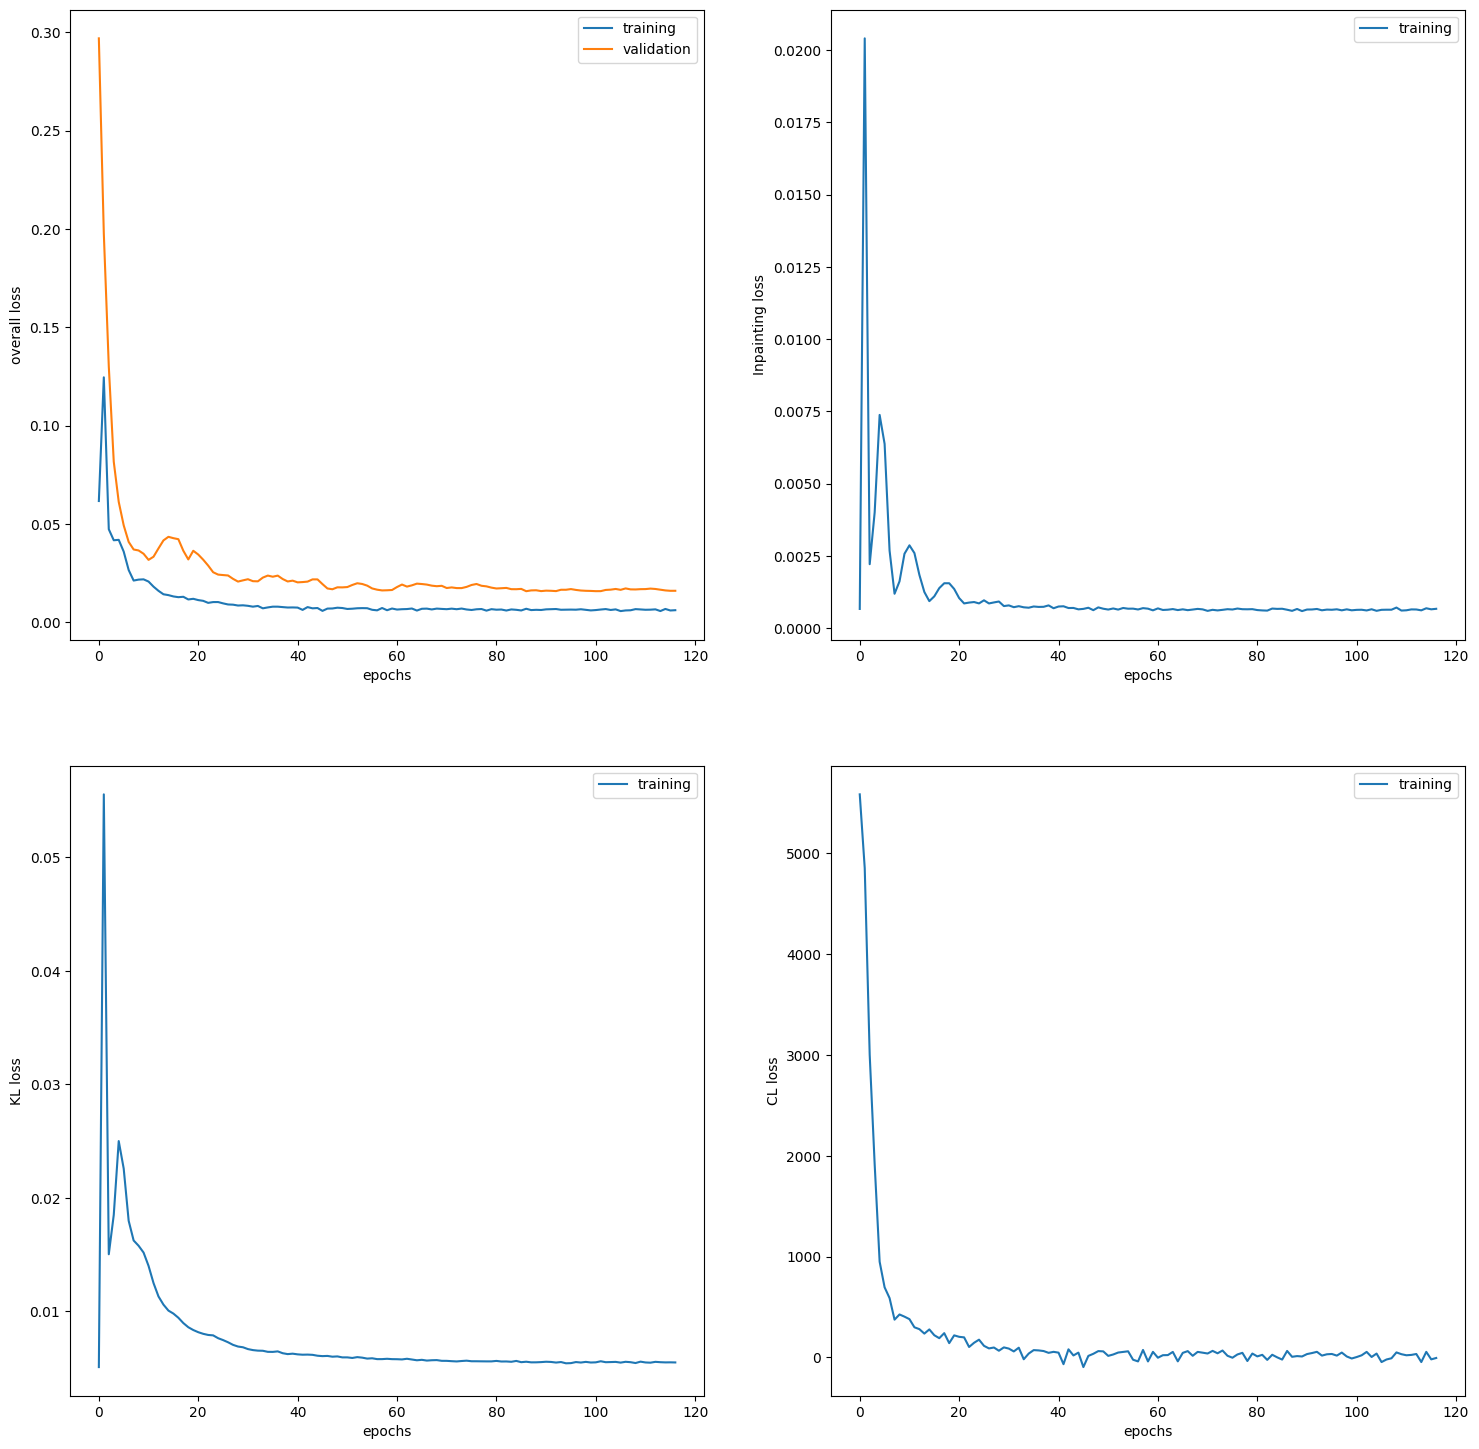

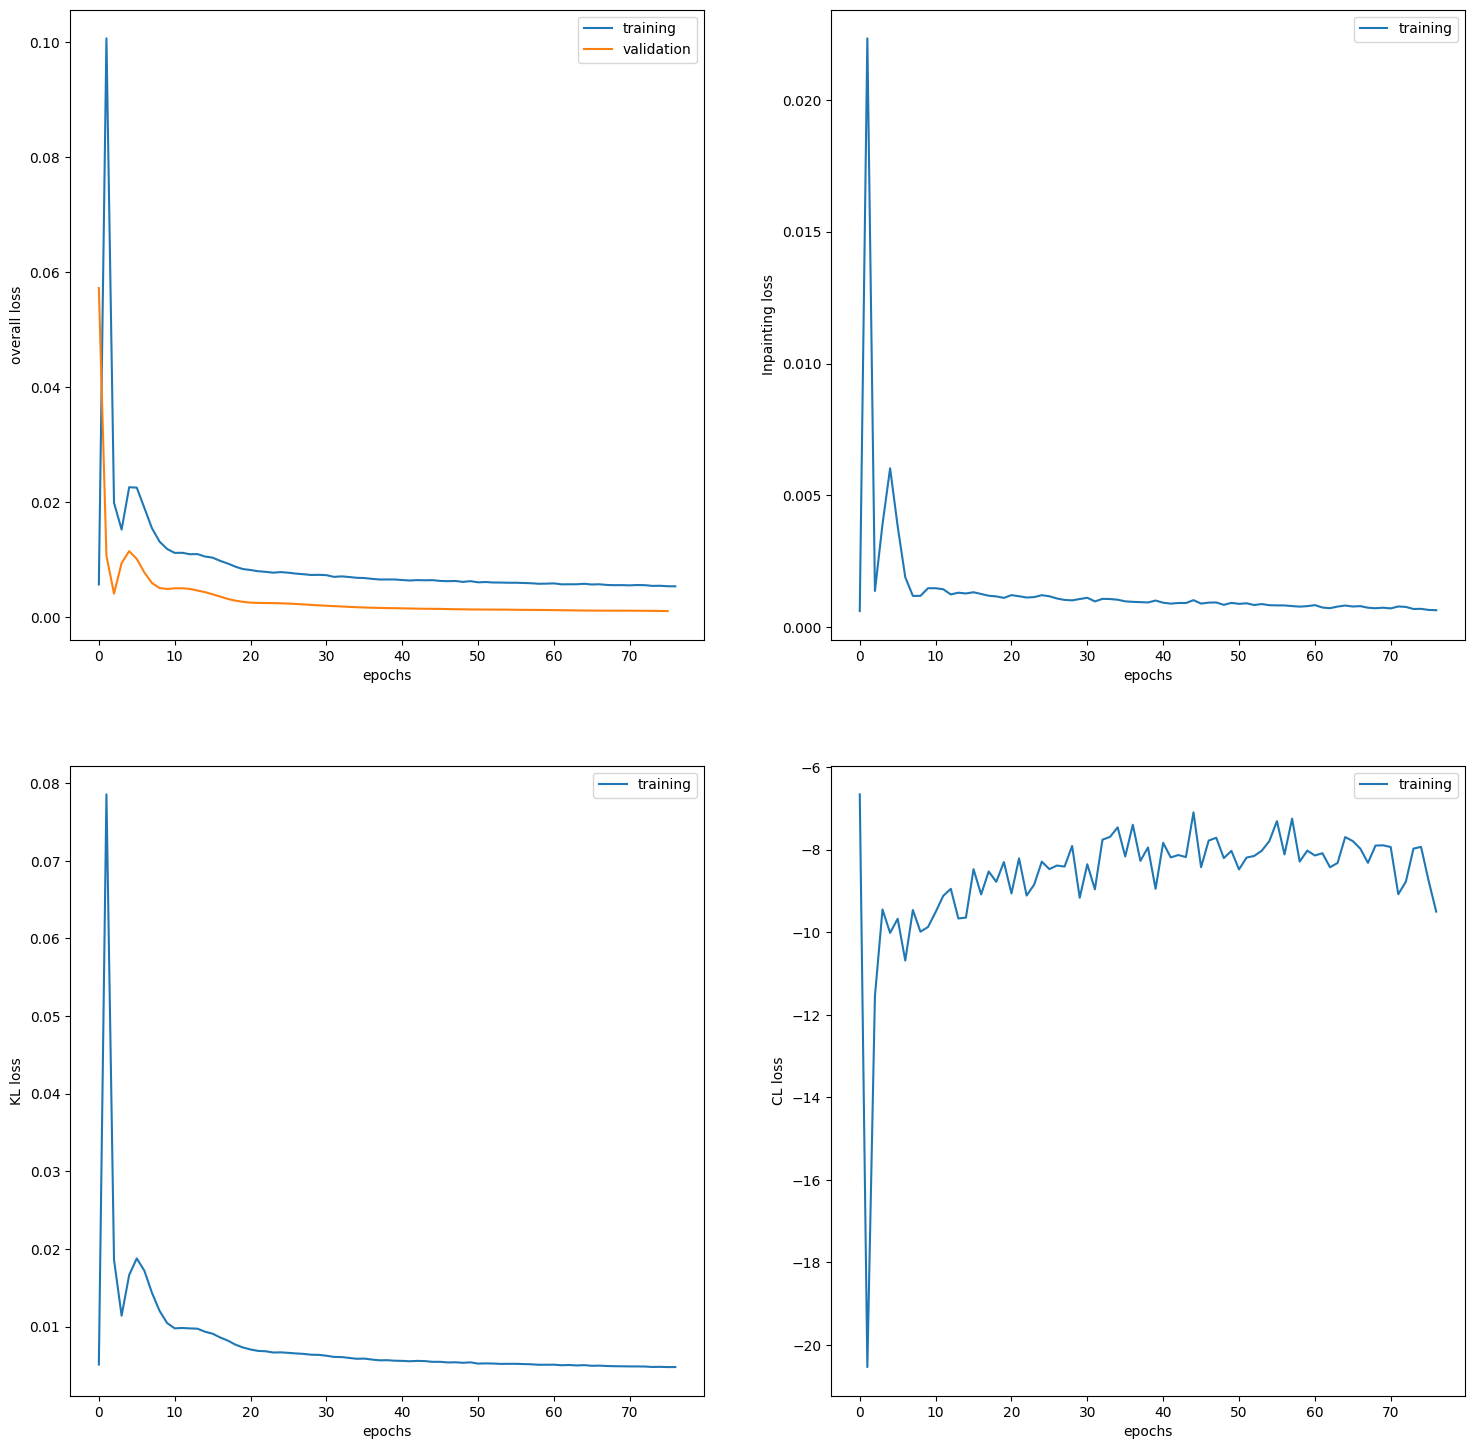

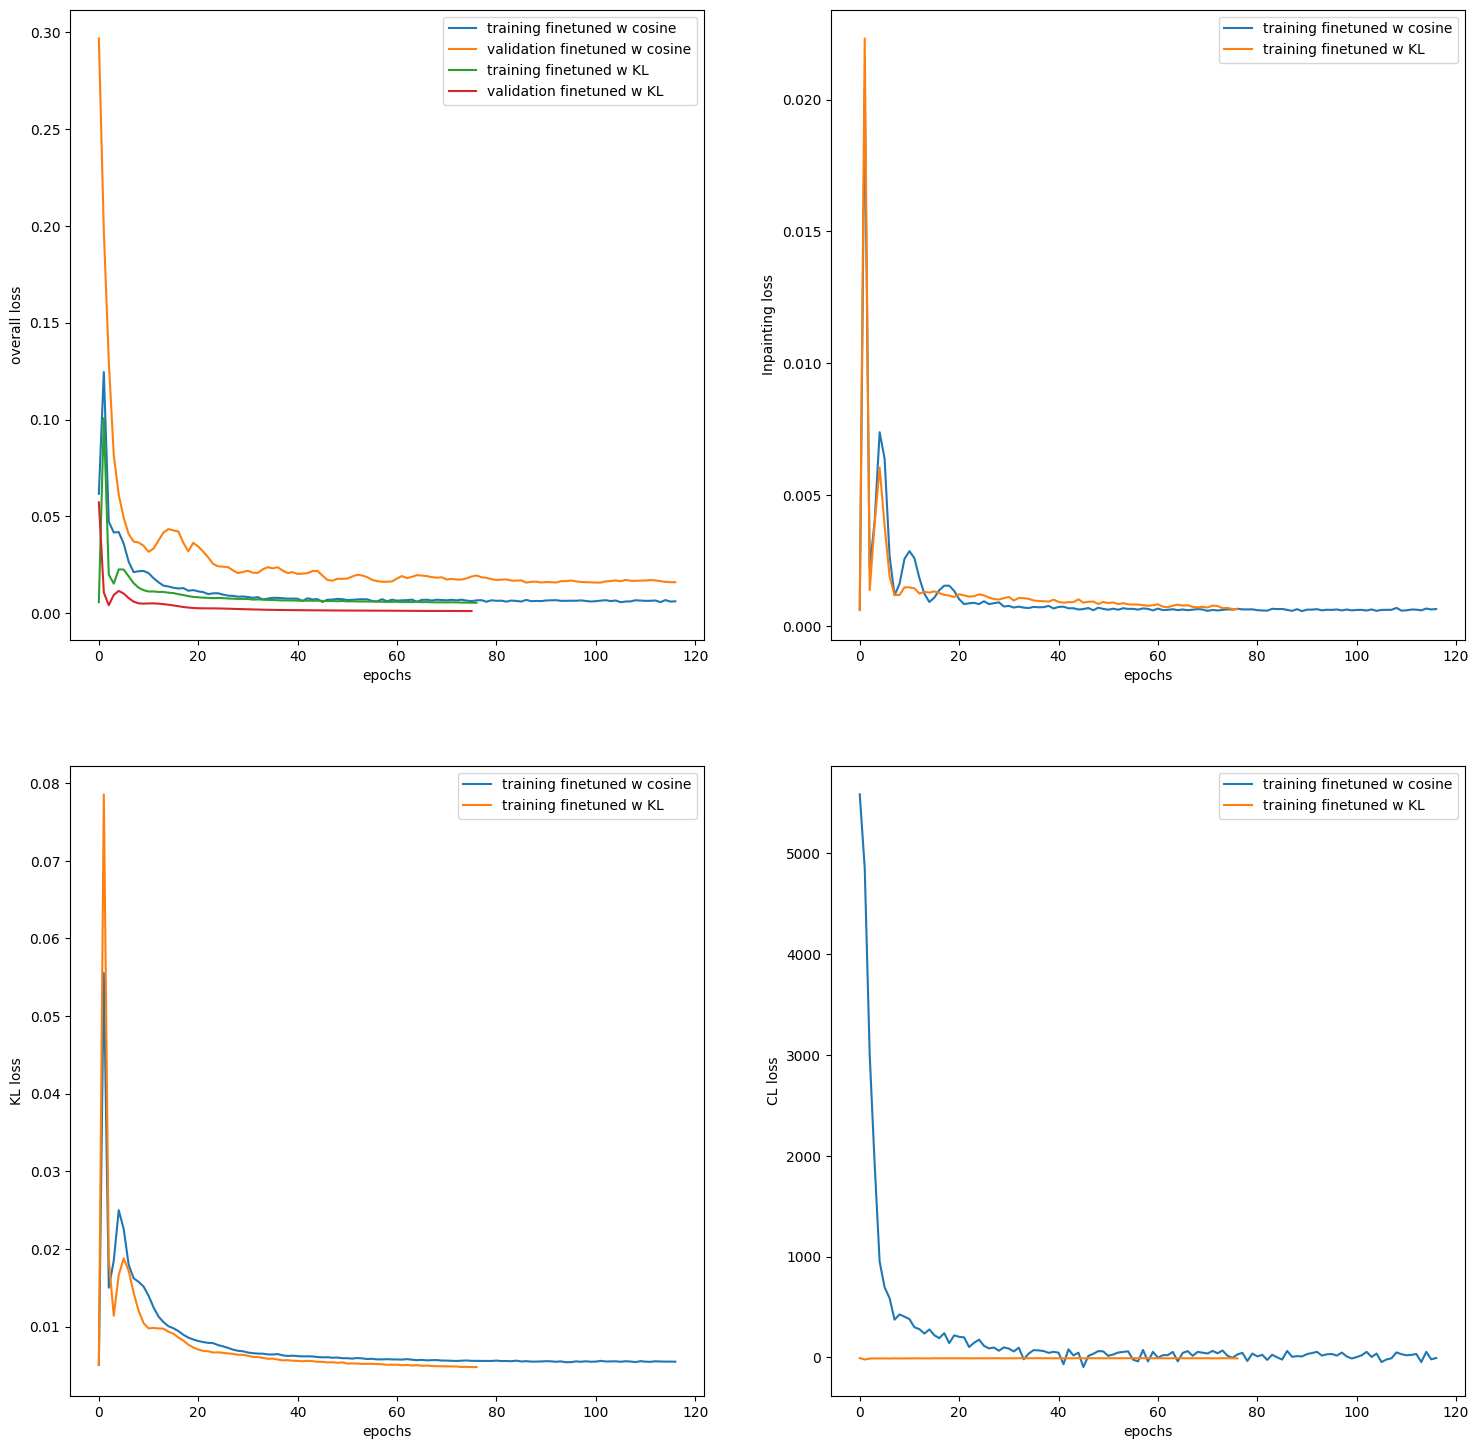

In [34]:
plot_loss(base_loss_dict)
plot_loss(cl_loss_dict)
plot_double_loss(base_loss_dict, cl_loss_dict)

In [22]:
golgi = get_normalized_tensor(load_data(data_dir+'golgi/*.tif'), model_base, device)
mitochondria = get_normalized_tensor(load_data(data_dir+'mitochondria/*.tif'), model_base, device)
granule = get_normalized_tensor(load_data(data_dir+'granules/*.tif'), model_base, device)

In [35]:
mode = ['euclidean distance', 'cosine similarity', 'kl divergence']
class_type = [golgi, mitochondria, granule]

In [24]:
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name

100%|██████████| 369/369 [00:23<00:00, 15.47it/s]


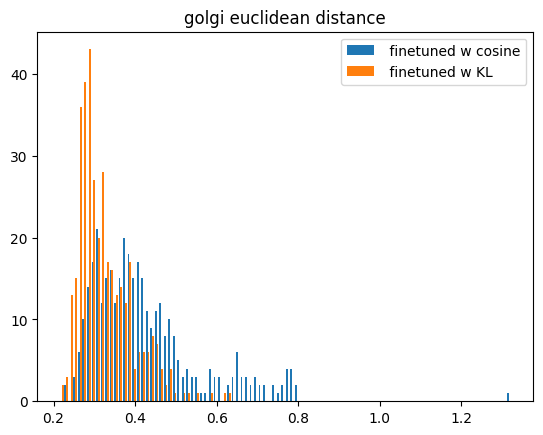

100%|██████████| 560/560 [00:36<00:00, 15.48it/s]


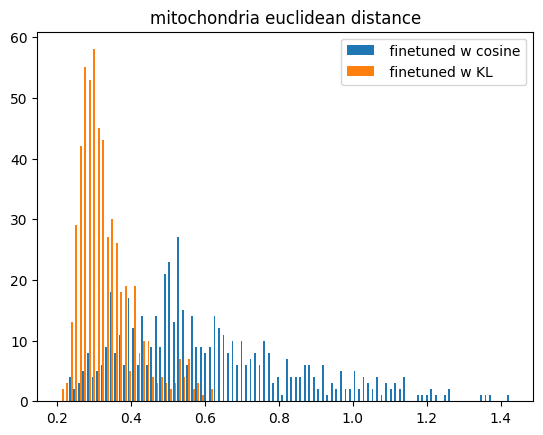

100%|██████████| 525/525 [00:33<00:00, 15.52it/s]


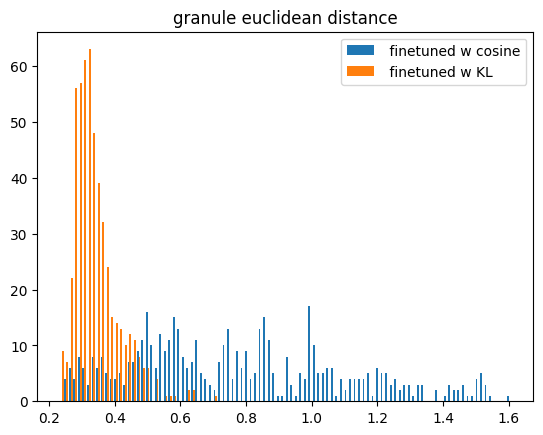

100%|██████████| 369/369 [00:23<00:00, 15.39it/s]


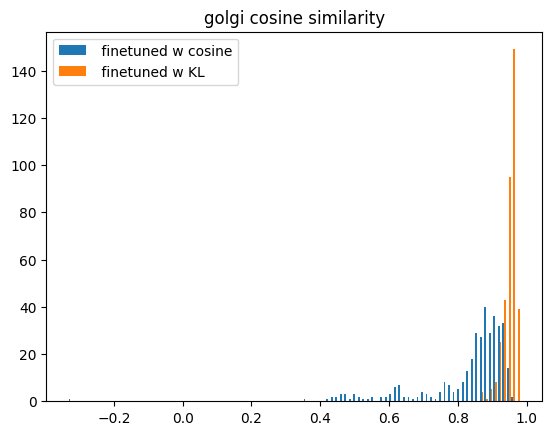

100%|██████████| 560/560 [00:36<00:00, 15.36it/s]


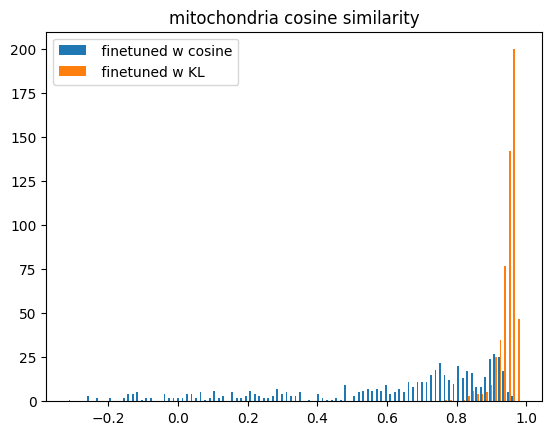

100%|██████████| 525/525 [00:33<00:00, 15.57it/s]


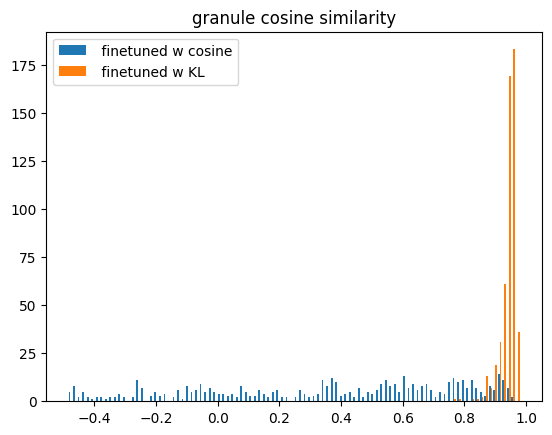

100%|██████████| 369/369 [00:24<00:00, 15.10it/s]


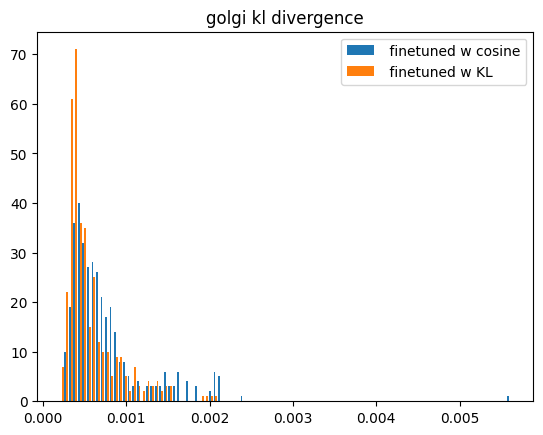

100%|██████████| 560/560 [00:36<00:00, 15.32it/s]


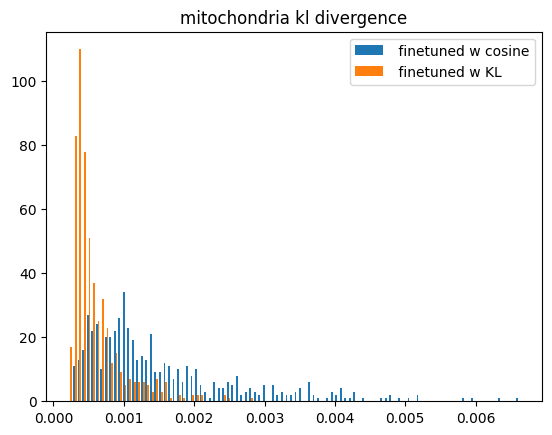

100%|██████████| 525/525 [00:34<00:00, 15.35it/s]


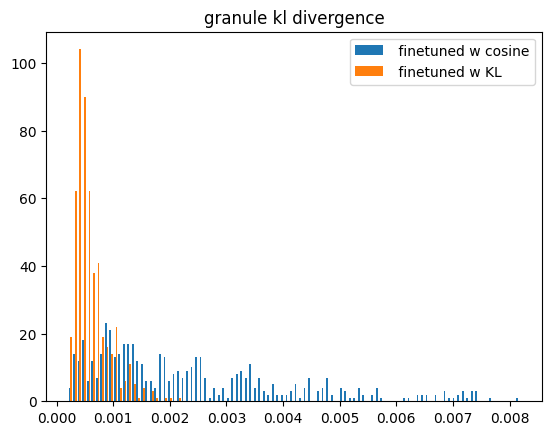

In [36]:
for dis_type in mode:
    for i in range(len(class_type)):
        cl_type = get_var_name(class_type[i])
        x = compute_pos_hist(class_type[i], model_base, dis_type)
        y = compute_pos_hist(class_type[i], model_cl, dis_type)
        plot_double_hist([x,y], [first_model, second_model], cl_type+' '+dis_type)

100%|██████████| 400/400 [00:25<00:00, 15.40it/s]


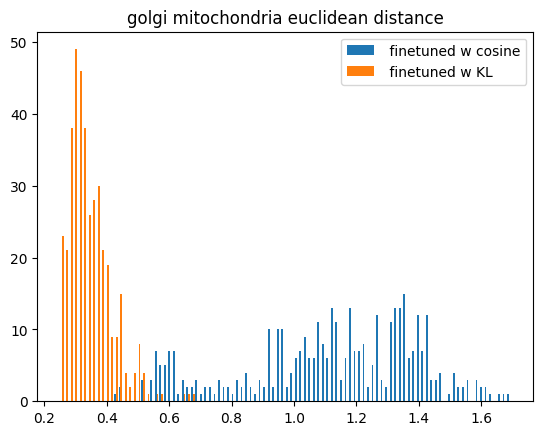

100%|██████████| 400/400 [00:25<00:00, 15.49it/s]


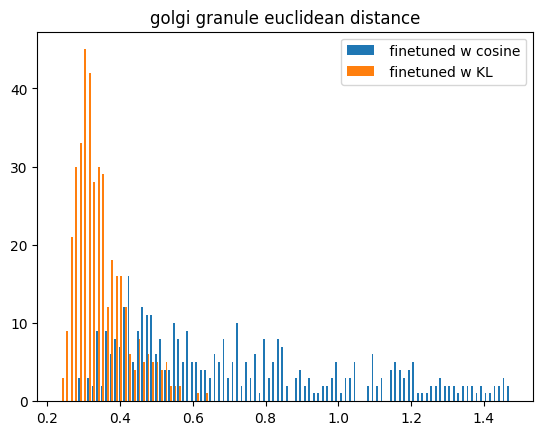

100%|██████████| 400/400 [00:25<00:00, 15.40it/s]


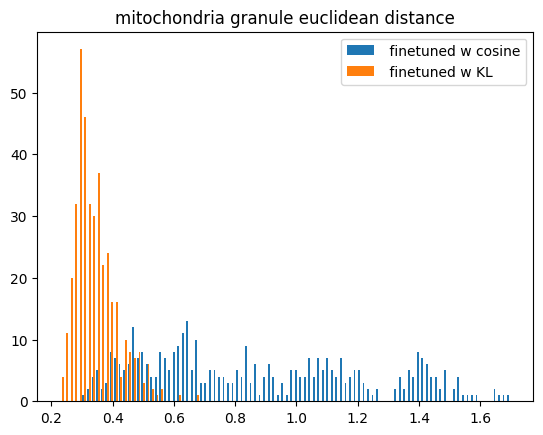

100%|██████████| 400/400 [00:25<00:00, 15.48it/s]


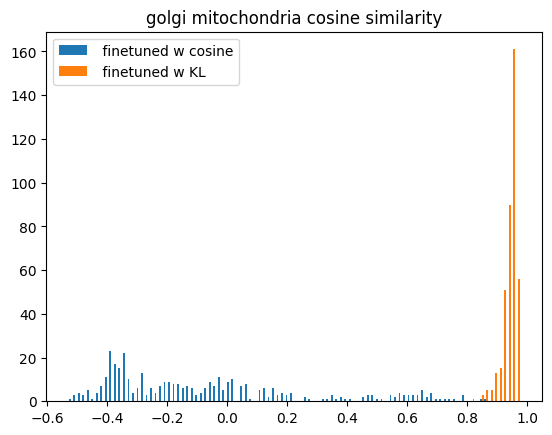

100%|██████████| 400/400 [00:25<00:00, 15.49it/s]


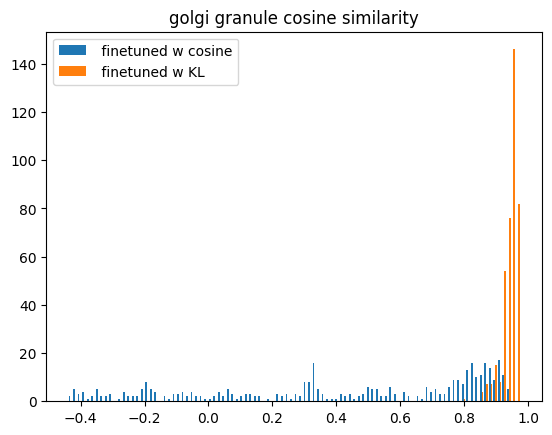

100%|██████████| 400/400 [00:25<00:00, 15.54it/s]


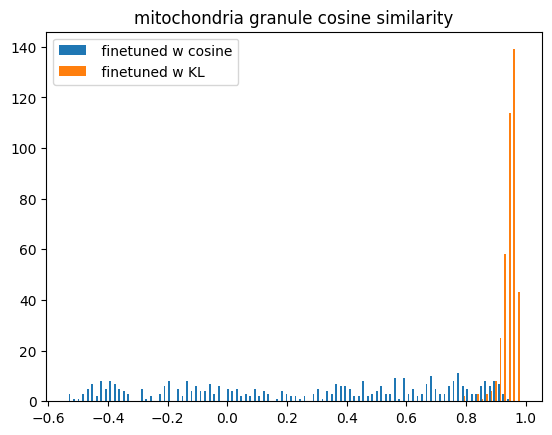

100%|██████████| 400/400 [00:26<00:00, 15.28it/s]


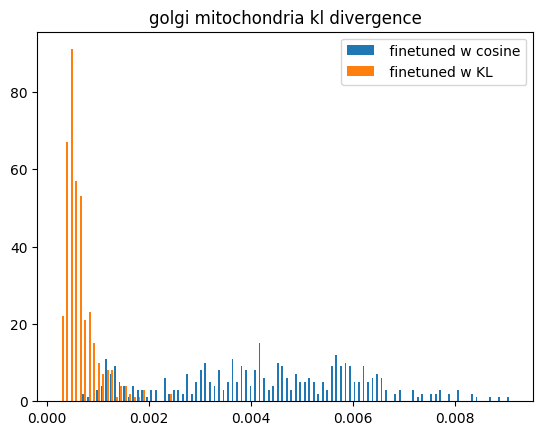

100%|██████████| 400/400 [00:26<00:00, 15.36it/s]


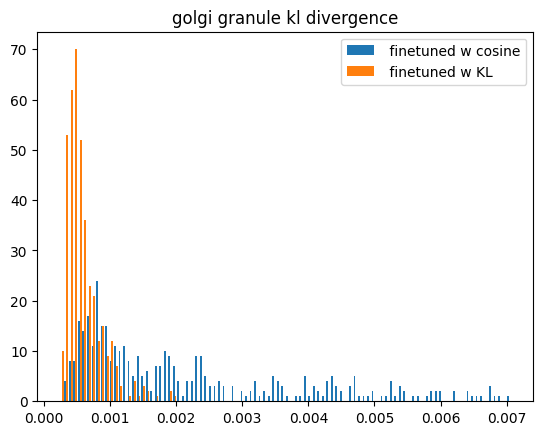

100%|██████████| 400/400 [00:26<00:00, 15.27it/s]


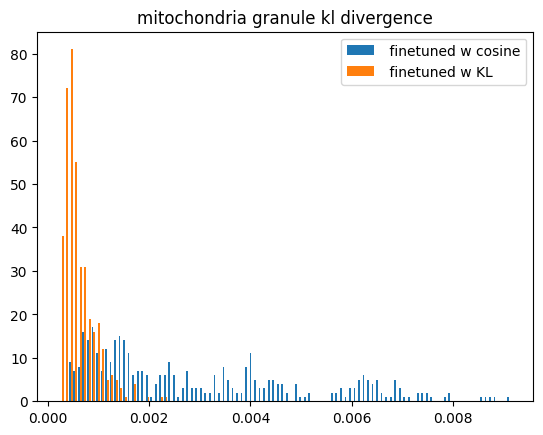

In [37]:
for dis_type in mode:
    for i in range(len(class_type)):
        for j in range(i+1,len(class_type)):
            cl_type = get_var_name(class_type[i])
            opp_type = get_var_name(class_type[j])
            x = compute_neg_hist(class_type[i], class_type[j], limit, model_base, dis_type)
            y = compute_neg_hist(class_type[i], class_type[j], limit, model_cl, dis_type)
            plot_double_hist([x,y], [first_model, second_model], cl_type+' '+opp_type+' '+dis_type)

In [38]:
def plot_triple_hist(hist, label, title):
    n_bins = 20
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    fig.set_figwidth(18)
    fig.set_figheight(9)
    axs[0].hist(hist[0], bins=n_bins, label=label)
    axs[0].set_title(title[0])
    axs[0].legend()
    axs[1].hist(hist[1], bins=n_bins, label=label)
    axs[1].set_title(title[1])
    axs[1].legend()
    plt.show()

 70%|███████   | 280/400 [00:18<00:07, 15.62it/s]

100%|██████████| 400/400 [00:25<00:00, 15.48it/s]


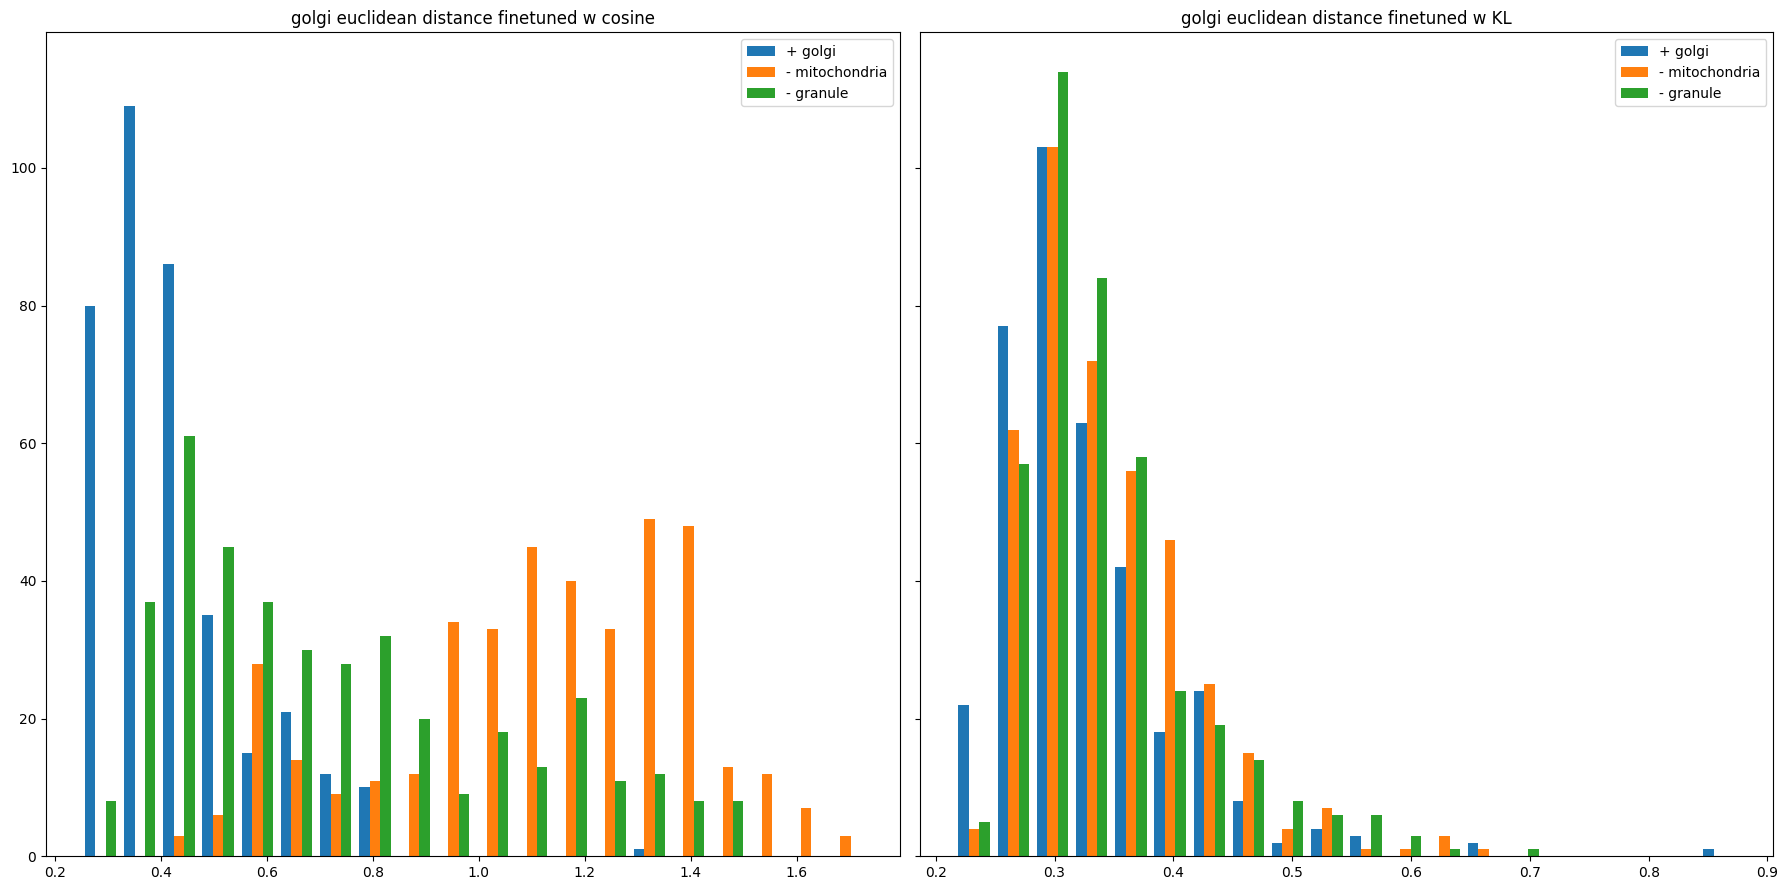

100%|██████████| 400/400 [00:25<00:00, 15.47it/s]


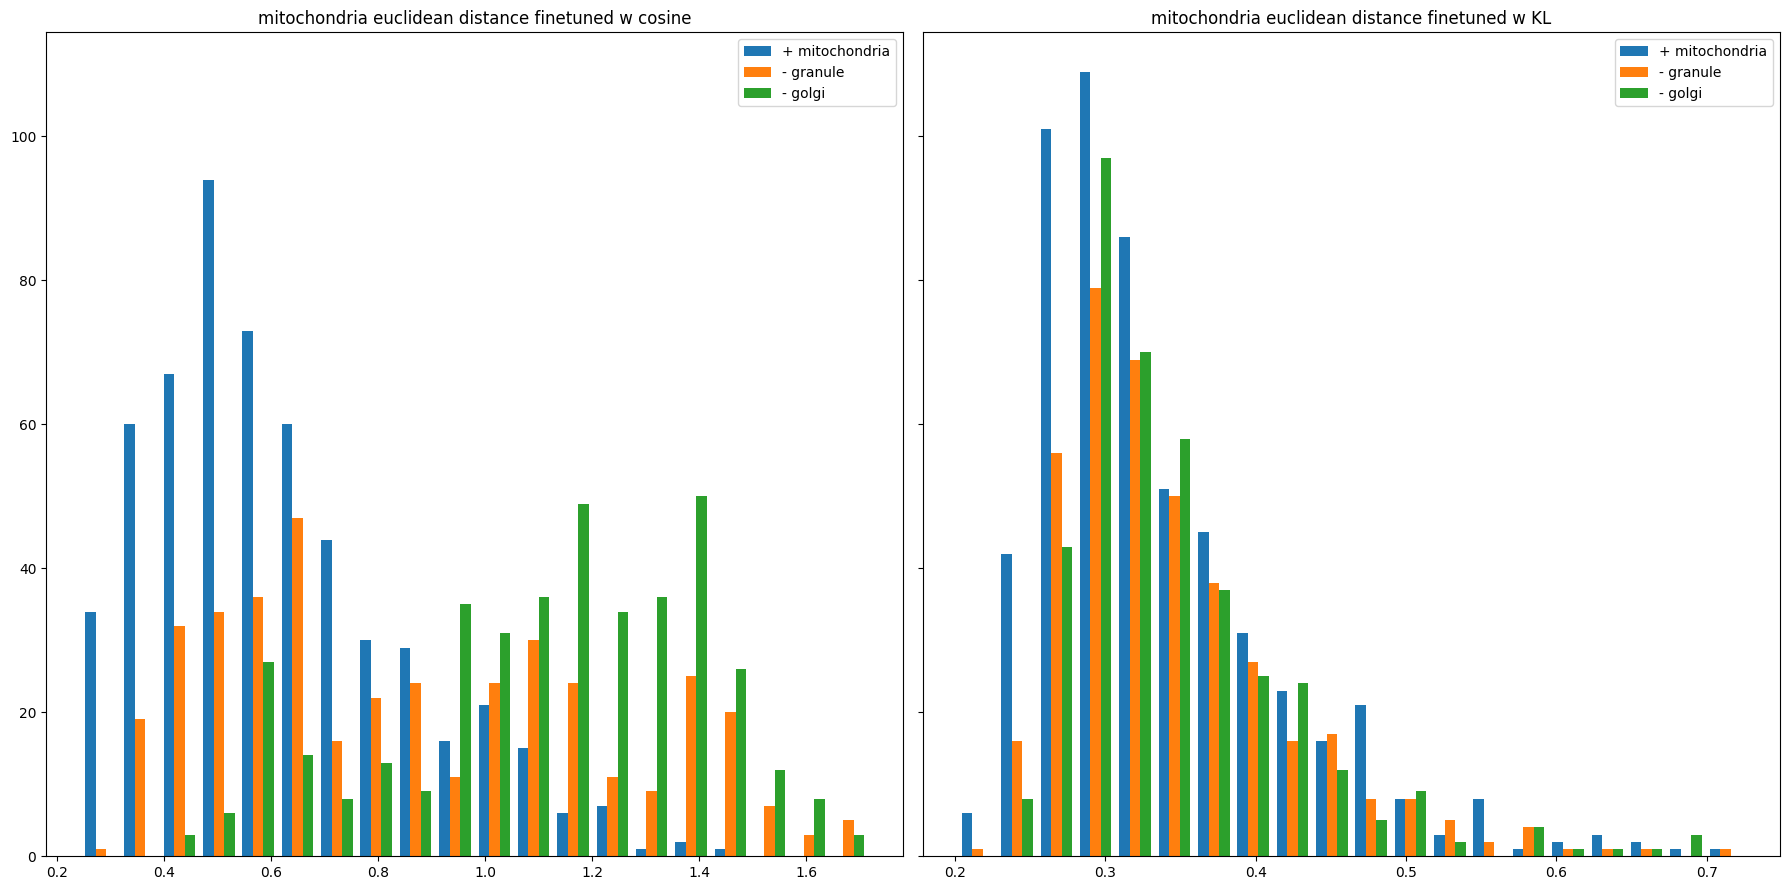

100%|██████████| 400/400 [00:25<00:00, 15.54it/s]


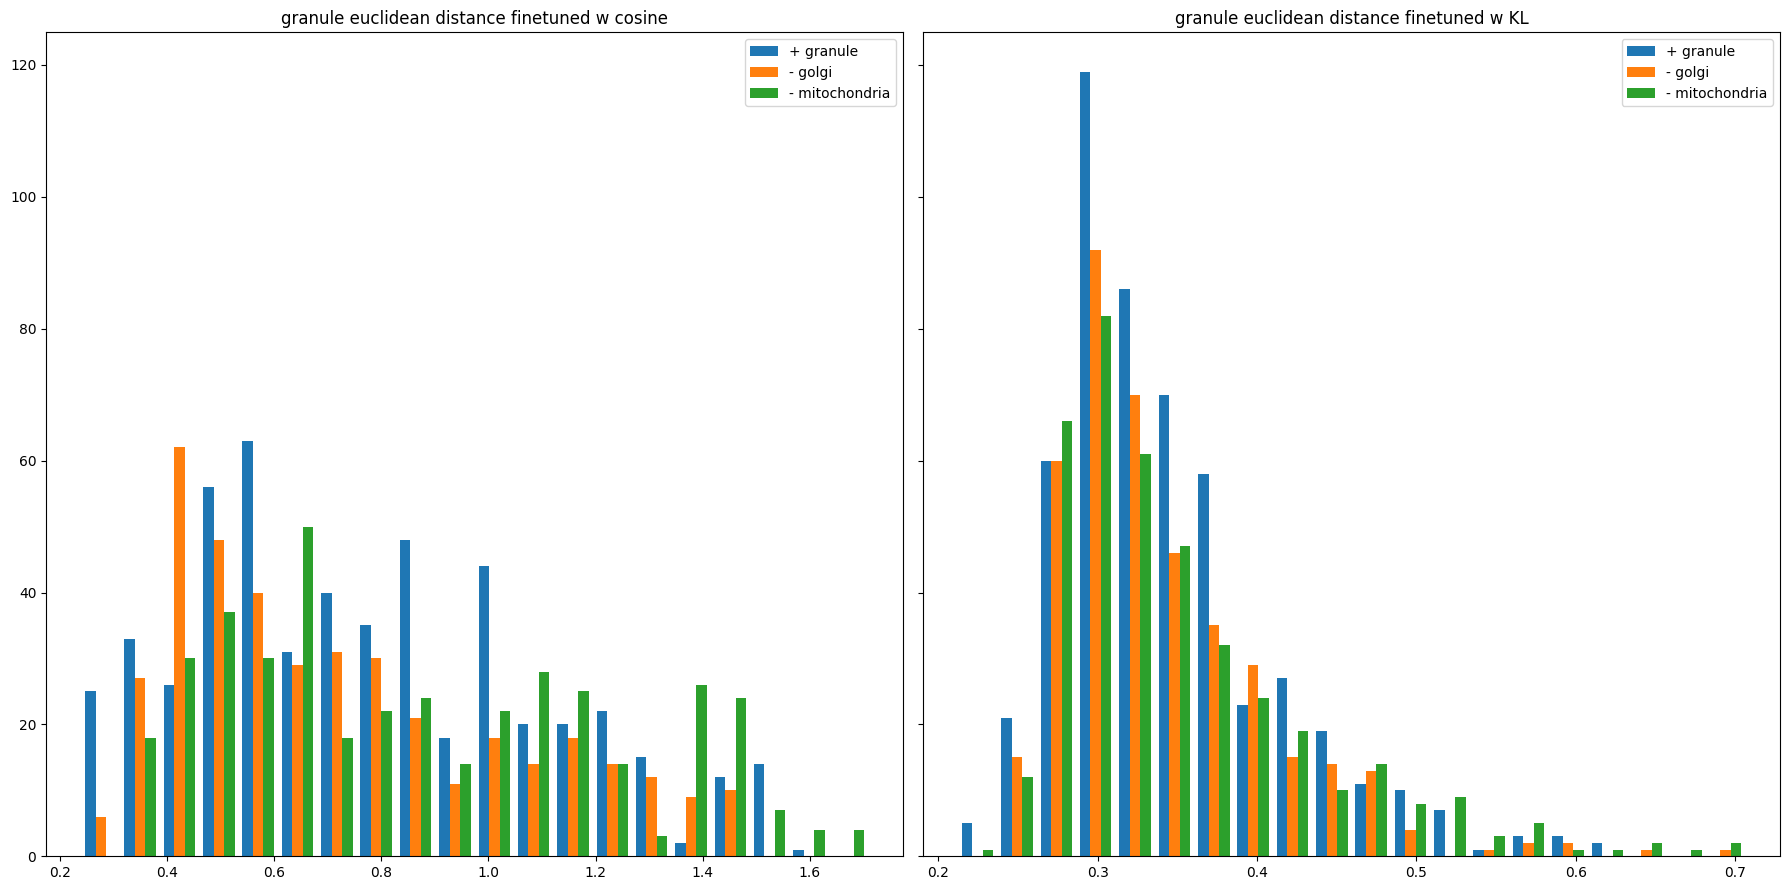

100%|██████████| 400/400 [00:25<00:00, 15.55it/s]


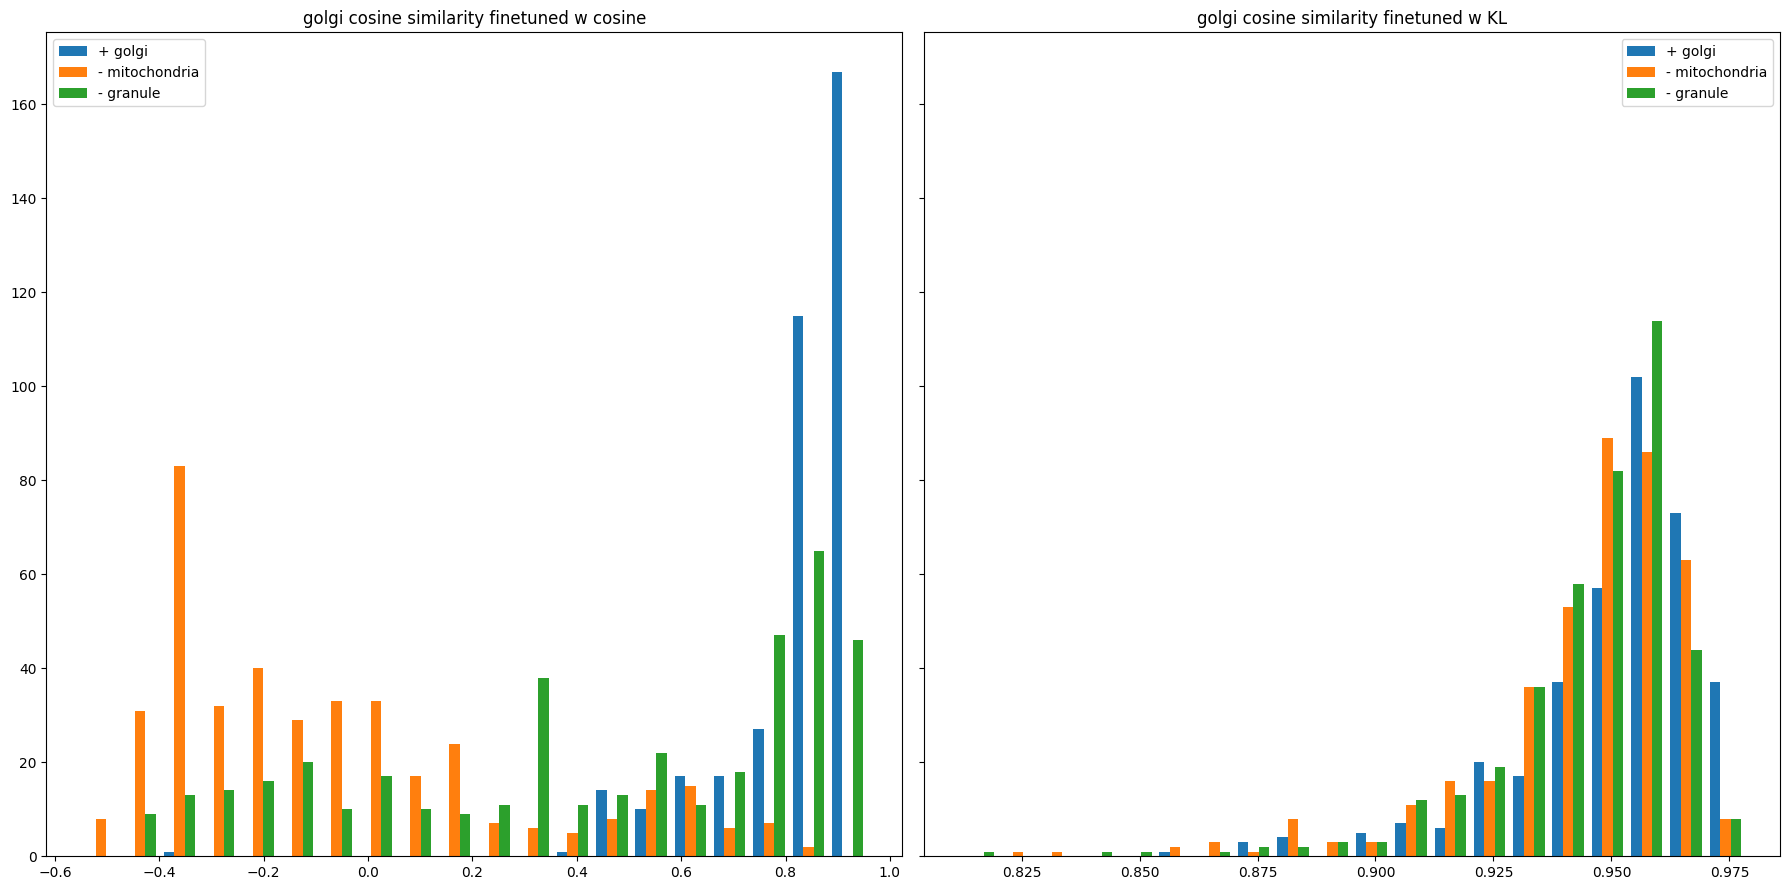

100%|██████████| 400/400 [00:25<00:00, 15.54it/s]


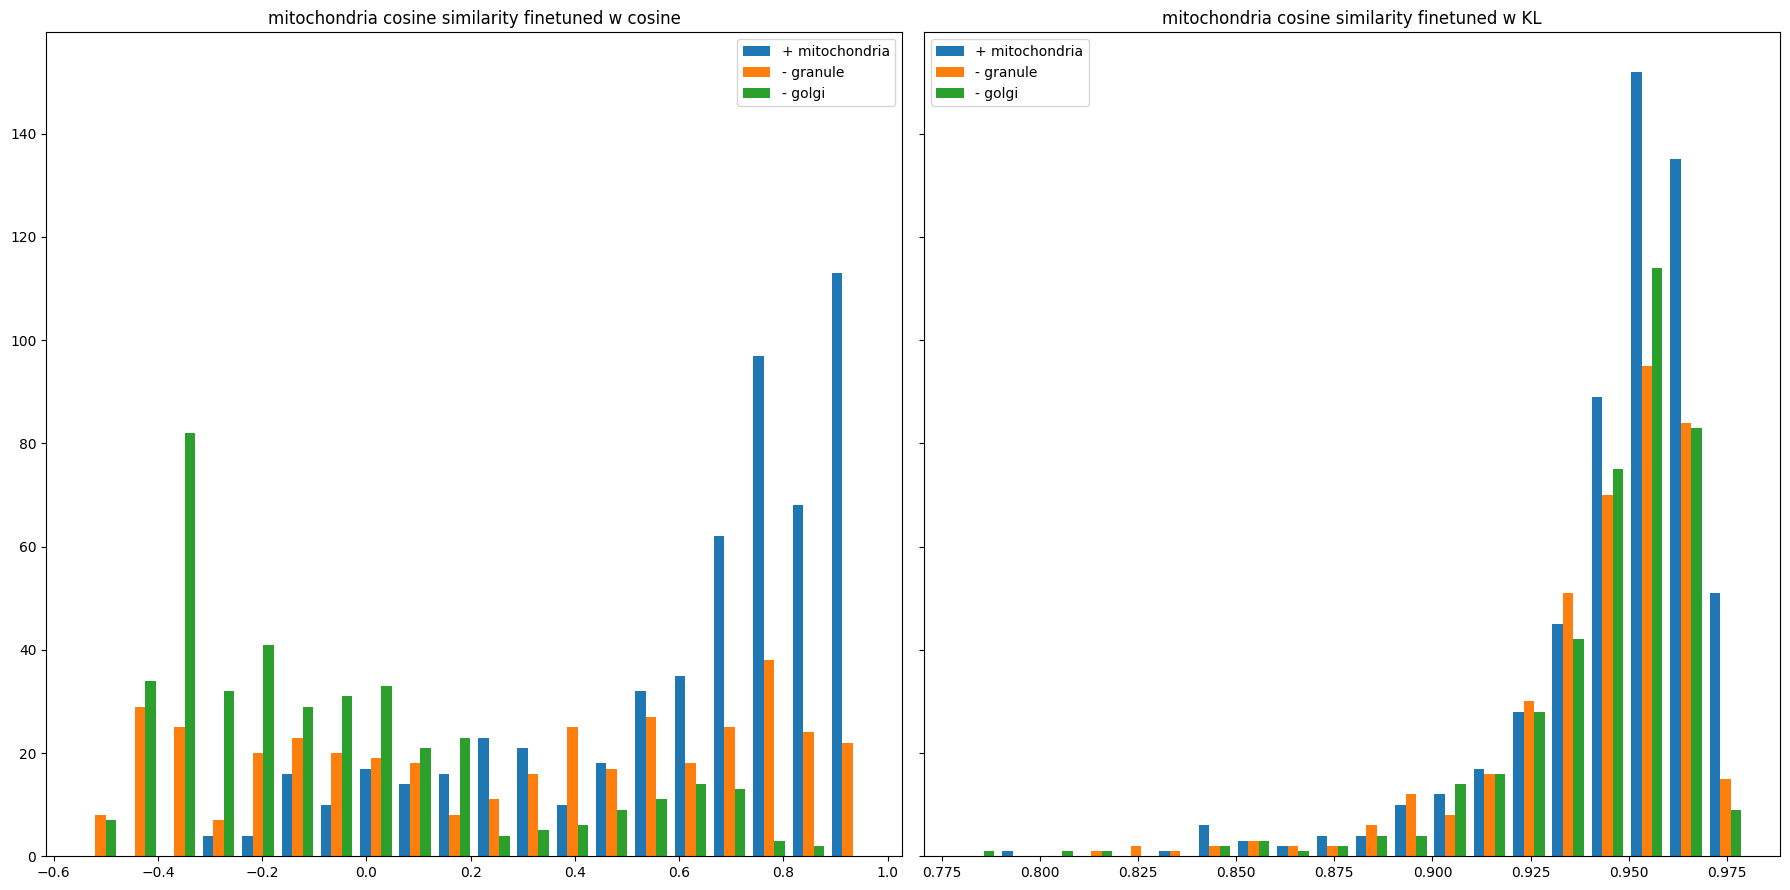

100%|██████████| 400/400 [00:26<00:00, 15.32it/s]


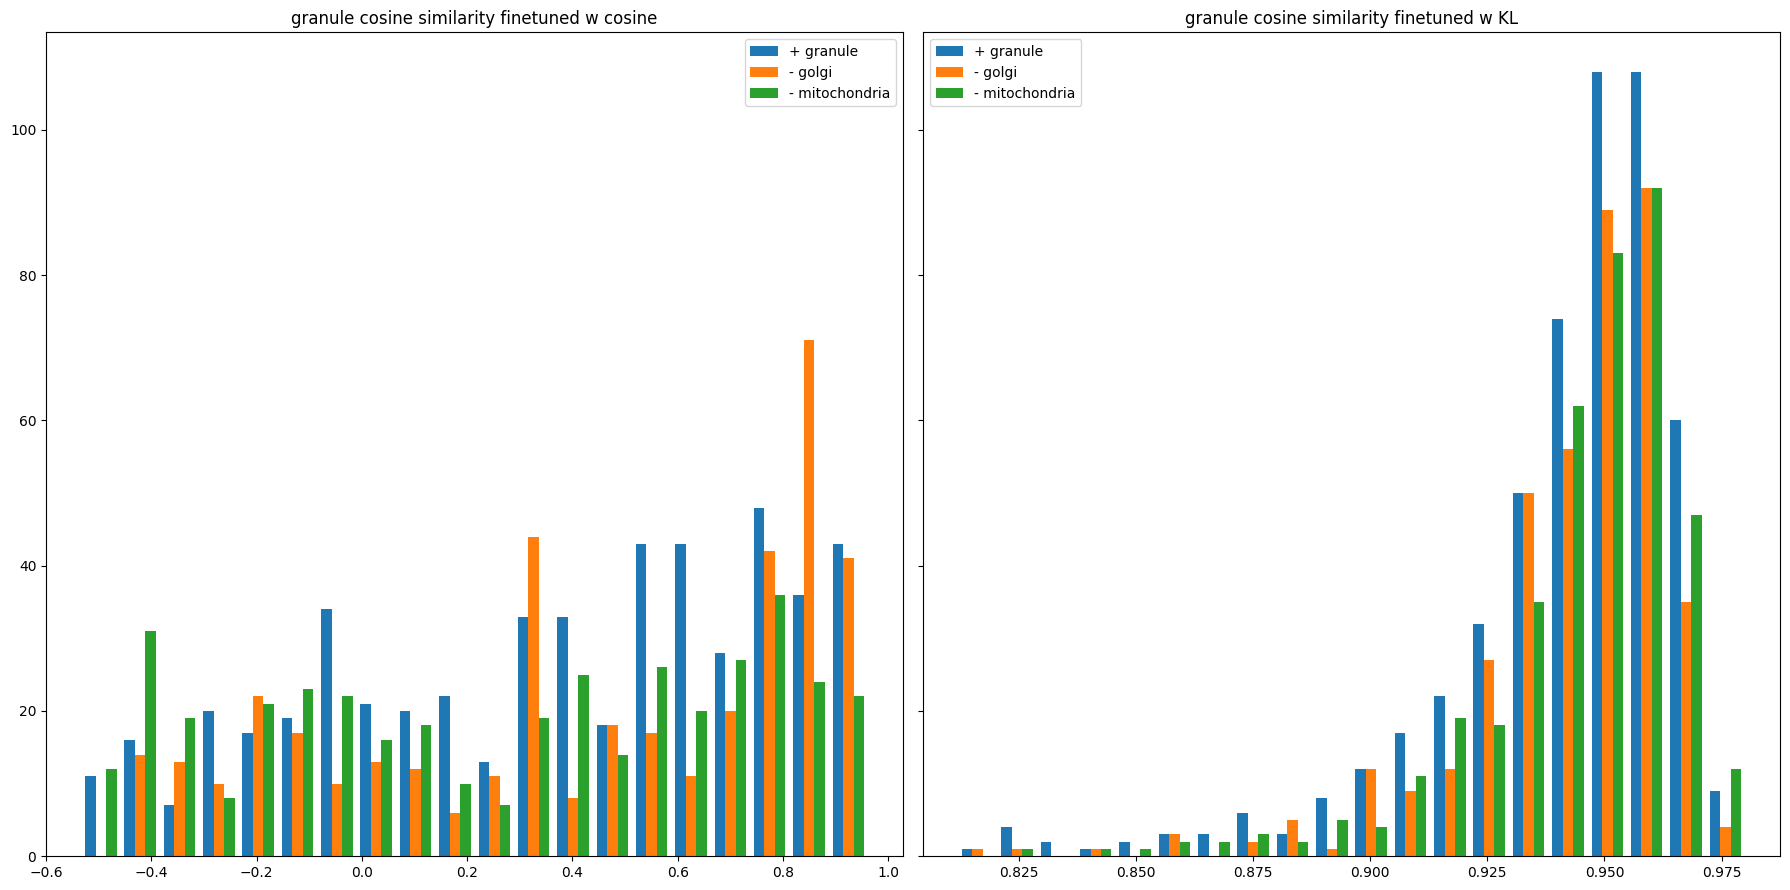

100%|██████████| 400/400 [00:26<00:00, 15.23it/s]


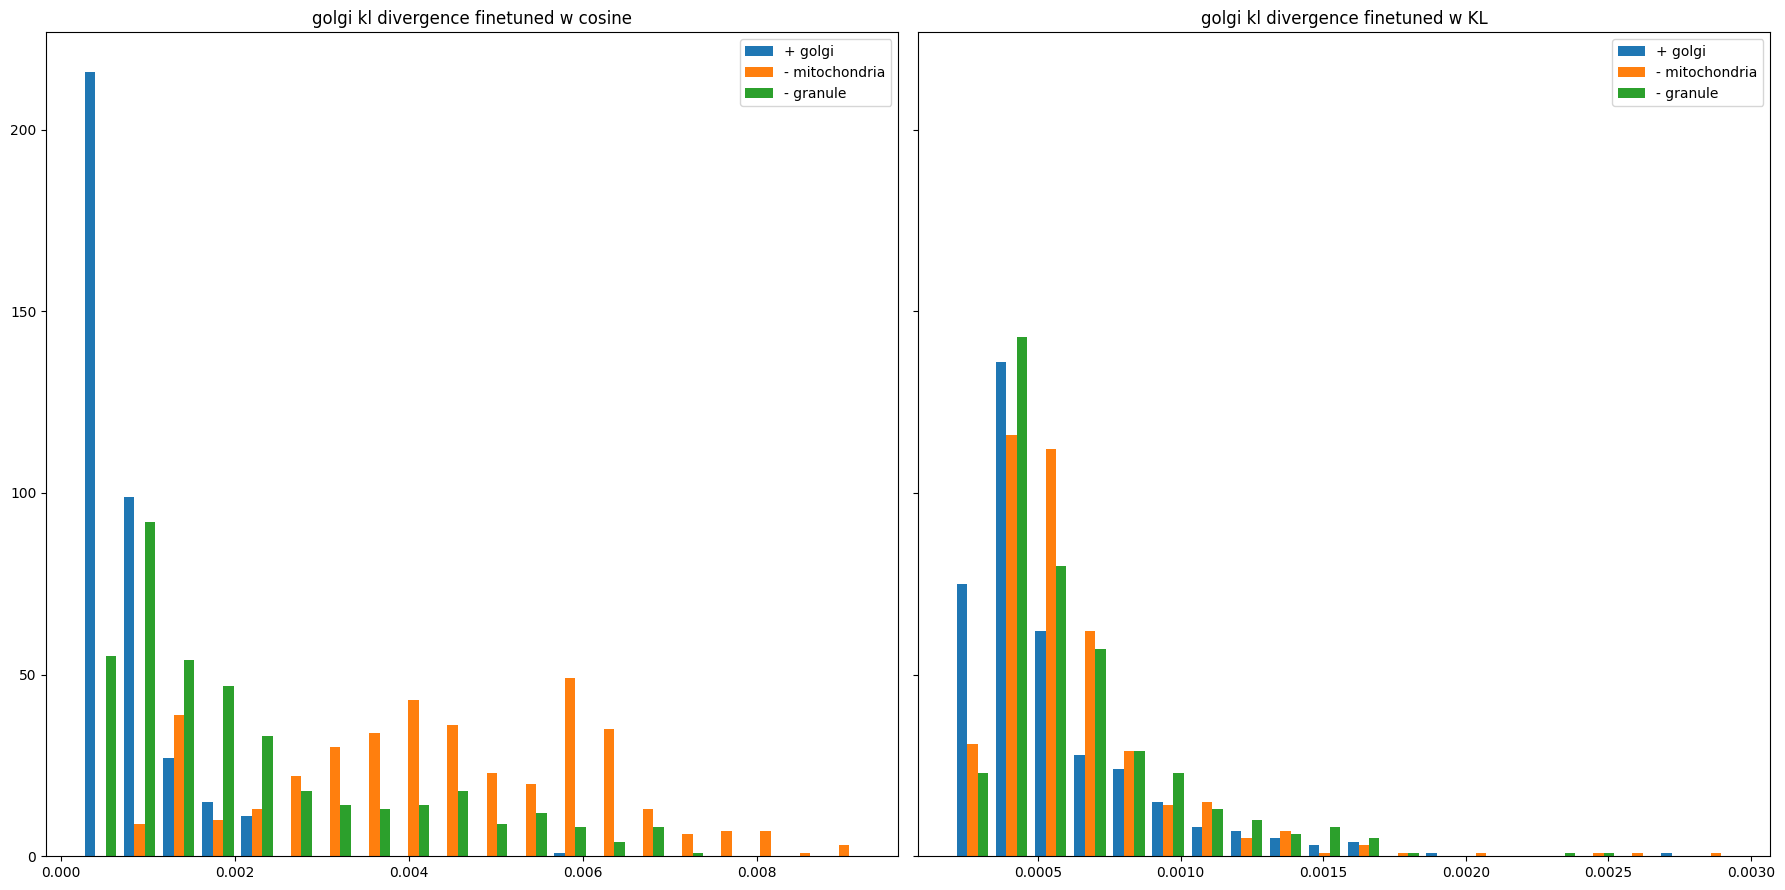

100%|██████████| 400/400 [00:26<00:00, 15.30it/s]


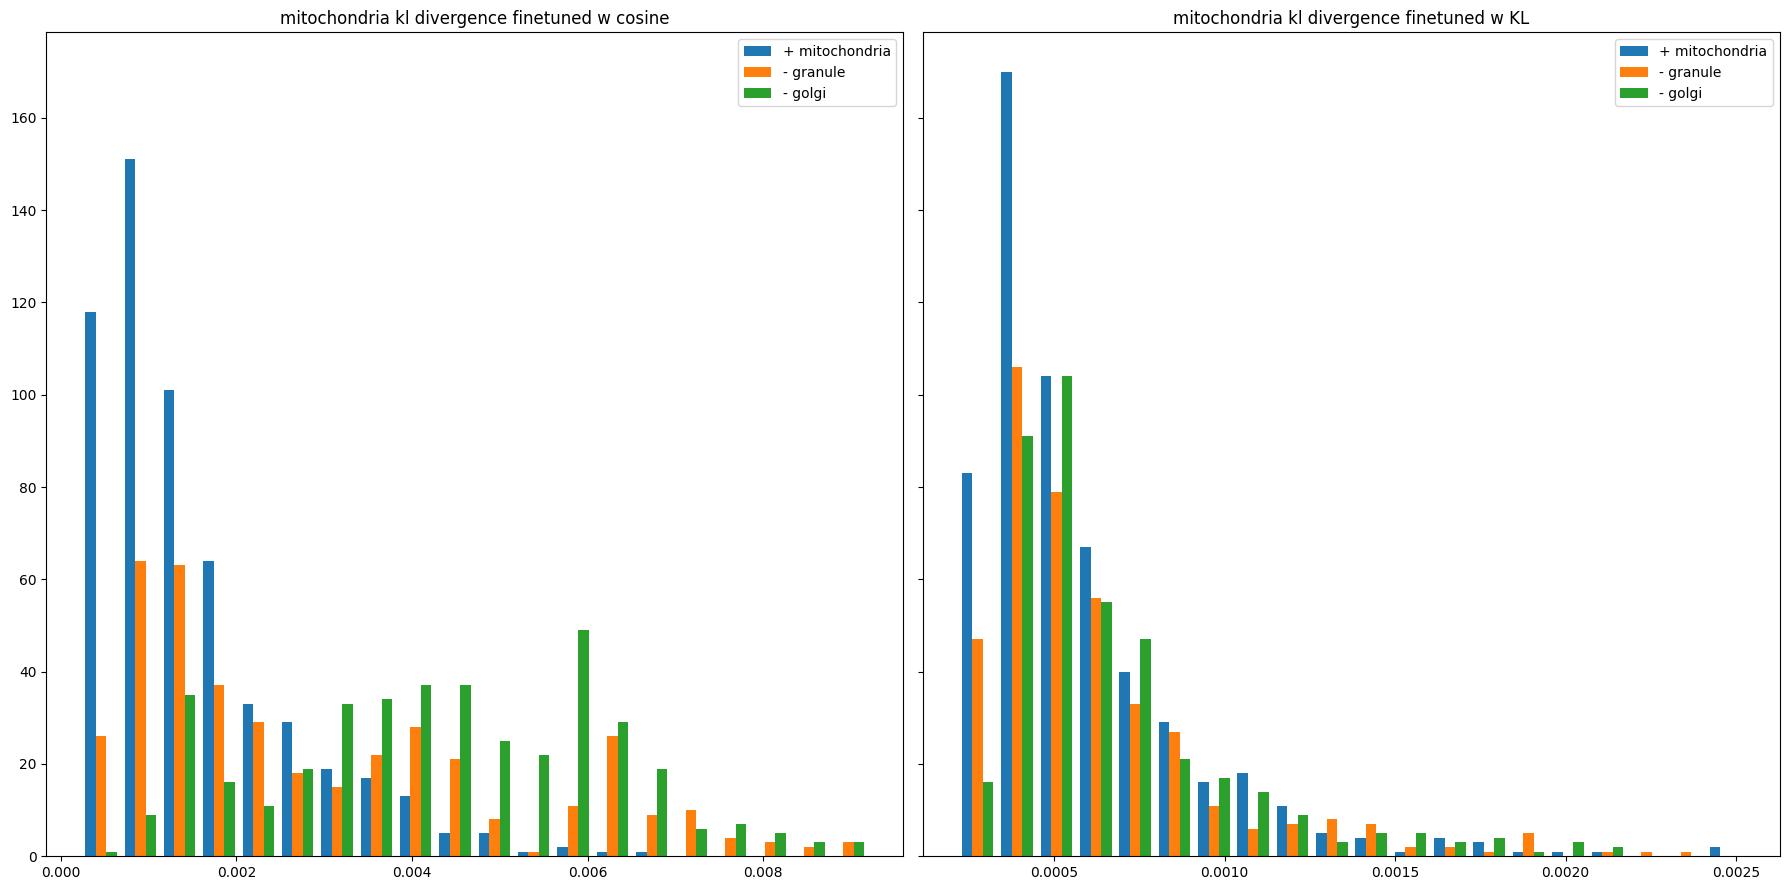

100%|██████████| 400/400 [00:26<00:00, 15.26it/s]


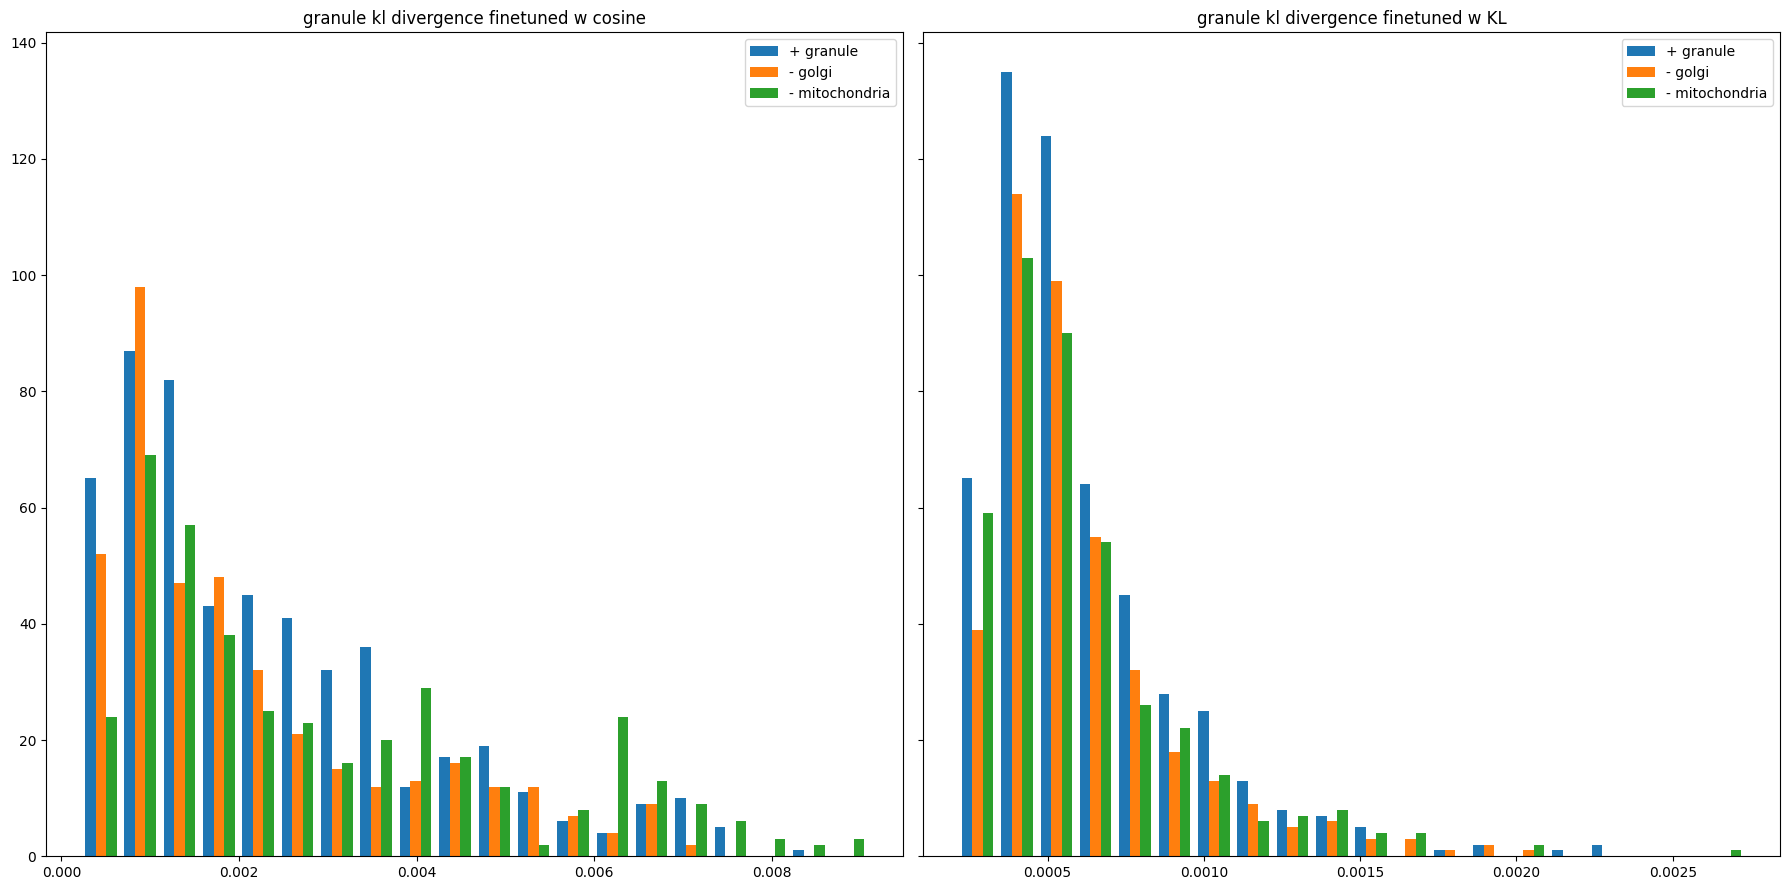

In [39]:
for dis_type in mode:
    for i in range(len(class_type)):
        j = (i+1)%len(class_type)
        k = (i+2)%len(class_type)
        cl_type = get_var_name(class_type[i])
        opp_1 = get_var_name(class_type[j])
        opp_2 = get_var_name(class_type[k])
        x = compute_pos_hist(class_type[i], model_base, dis_type)
        y = compute_neg_hist(class_type[i], class_type[j], limit, model_base, dis_type)
        z = compute_neg_hist(class_type[i], class_type[k], limit, model_base, dis_type)
        a = compute_pos_hist(class_type[i], model_cl, dis_type)
        b = compute_neg_hist(class_type[i], class_type[j], limit, model_cl, dis_type)
        c = compute_neg_hist(class_type[i], class_type[k], limit, model_cl, dis_type)
        plot_triple_hist([[x,y,z],
                        [a,b,c]],
                        ['+ '+cl_type, '- '+opp_1, '- '+opp_2],
                        [cl_type+' '+dis_type+first_model,
                        cl_type+' '+dis_type+second_model])
